# Tech Challenge - Desenvolvimento de um modelo de Machine Learning para prever custos médicos

Para iniciar o tech challenge eu escolhi uma base no kaggle chamada "Medical Cost Personal Datasets".

Importação das bibliotecas necessárias

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

import numpy as np

%matplotlib inline

Carregar a base de dados e analisar as primeiras linhas para entender o conteúdo

In [5]:
dados = pd.read_csv('./data/insurance.csv')

dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


 Verificar os tipos de dados e valores ausentes

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
dados.shape

(1338, 7)

Verificar a distribuição dos dados numéricos

In [ ]:
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Verificar a distribuição dos dados visualmente para detectar possíveis outliers

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

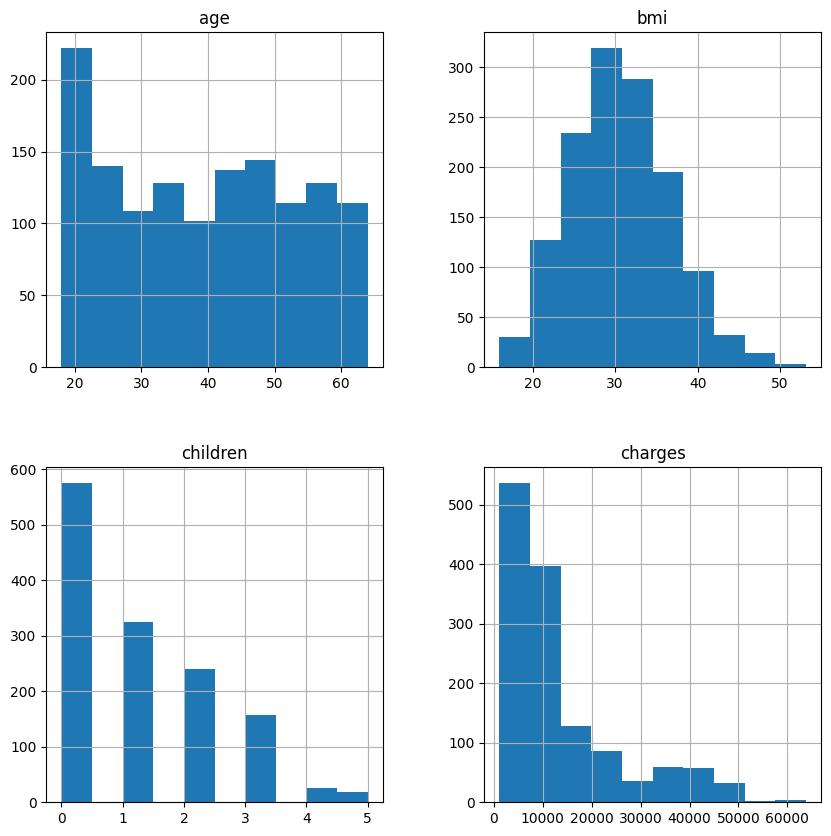

In [13]:
dados.hist(figsize=(10, 10))

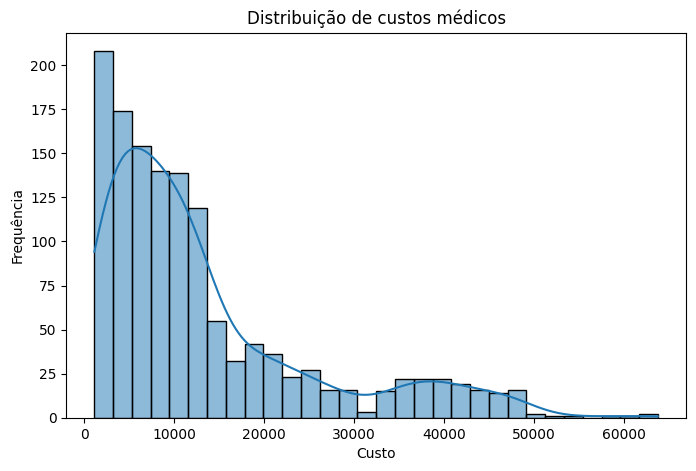

In [26]:
#  Distribuição de Custos médicos
plt.figure(figsize=(8, 5))
sns.histplot(dados['charges'], bins=30, kde=True)
plt.title('Distribuição de custos médicos')
plt.xlabel('Custo')
plt.ylabel('Frequência')
plt.show()

In [20]:
# Boxplot de Custo médico por Fumante e Região
fig = px.box(dados, x="region", y="charges", 
             color="smoker", 
             title="Distribuição dos Custos por Região e Tabagismo")
fig.show()

In [22]:
# Relação entre Idade e Custo médico
fig = px.scatter(dados, x="age", y="charges", 
                 color="smoker", size="bmi", 
                 hover_data=["sex", "region", "children"],
                 title="Custos Médicos por Idade (colorido por fumante)")
fig.show()


In [27]:
fig = px.scatter(dados, x="bmi", y="charges", 
                 trendline="ols", 
                 title="Correlação entre IMC e Custos Médicos")
fig.show()

Aqui podemos ver a correlação entre as variáveis numéricas. Aqui, usamos o método de Pearson para calcular a correlação de Pearson. Escolhi a de Pearson pois esses dados são contínuos ou discretos numericos.

Podemos também avaliar com o resultado do heatmap que a idade possui uma correlação positiva forte com o gasto médico.

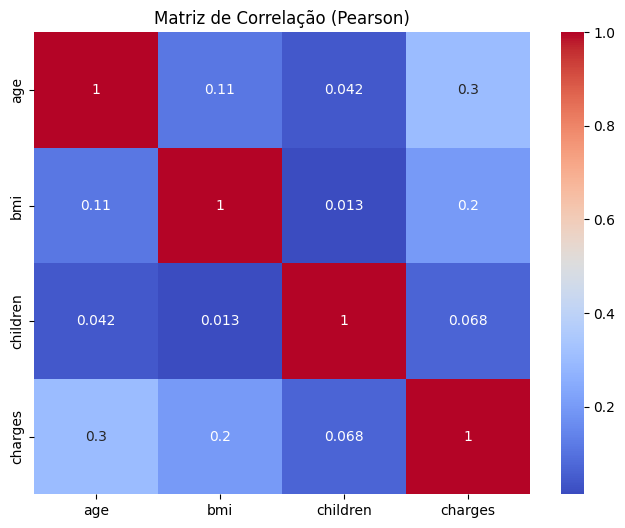

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(dados.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação (Pearson)')
plt.show()


No comando abaixo, verificamos a quantidade de pacientes por gênero. podemos ver que a quantidade dos dois é basicamente igual.

In [17]:
dados["sex"].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

Nos proximos dois graficos verificamos que a região não tem uma relação significativa com o gasto médico ou se é ou não fumante.

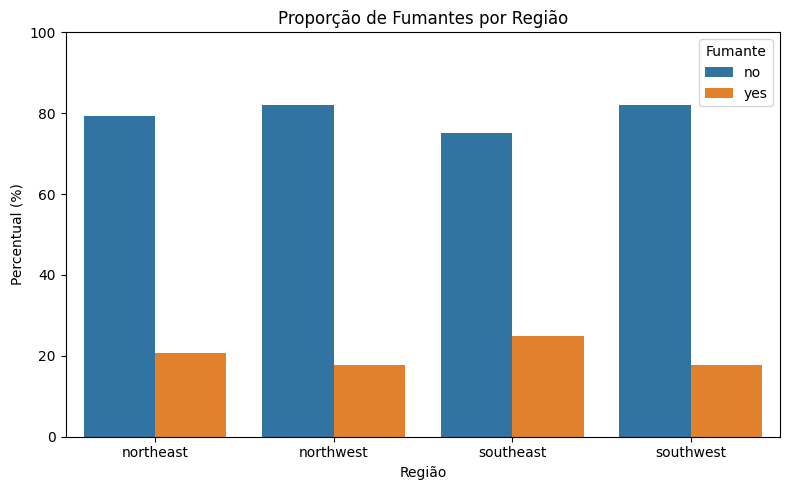

In [30]:
# Tabela de proporções por região
smoker_region_pct = pd.crosstab(dados['region'], dados['smoker'], normalize='index') * 100
smoker_region_pct = smoker_region_pct.round(2)

# Resetar índice para plotagem
smoker_region_pct = smoker_region_pct.reset_index()

# Converter para formato long (melt) para usar no seaborn
smoker_region_long = smoker_region_pct.melt(id_vars='region', var_name='smoker', value_name='percent')

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=smoker_region_long, x='region', y='percent', hue='smoker')
plt.title('Proporção de Fumantes por Região')
plt.ylabel('Percentual (%)')
plt.xlabel('Região')
plt.legend(title='Fumante')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

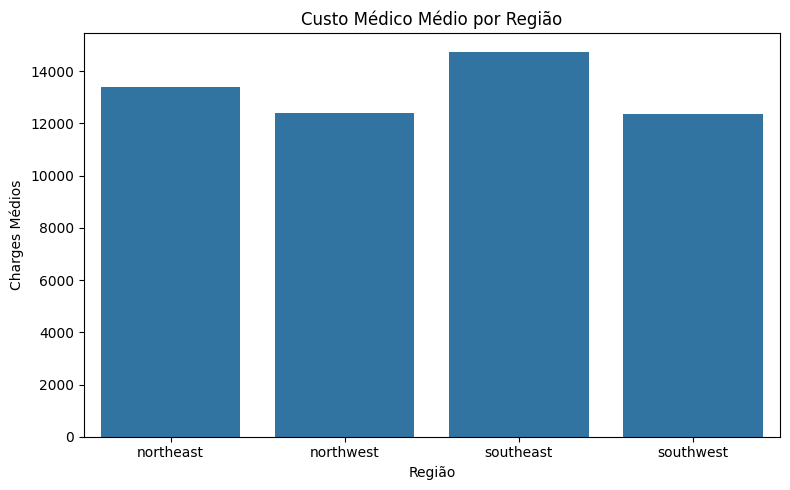

In [31]:
# Calcular custo médio por região
mean_charges_region = dados.groupby('region')['charges'].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_charges_region, x='region', y='charges')
plt.title('Custo Médico Médio por Região')
plt.ylabel('Charges Médios')
plt.xlabel('Região')
plt.tight_layout()
plt.show()

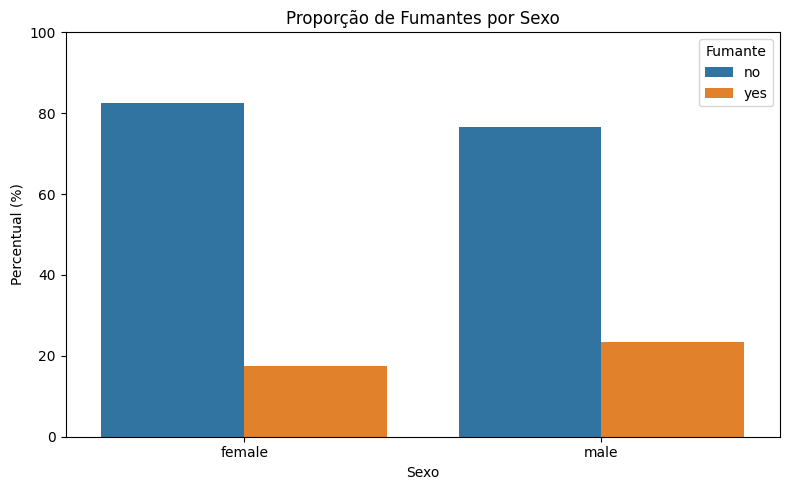

In [32]:
# Tabela de proporção de fumantes por sexo
smoker_sex_pct = pd.crosstab(dados['sex'], dados['smoker'], normalize='index') * 100
smoker_sex_pct = smoker_sex_pct.reset_index().melt(id_vars='sex', var_name='smoker', value_name='percent')

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=smoker_sex_pct, x='sex', y='percent', hue='smoker')
plt.title('Proporção de Fumantes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.legend(title='Fumante')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Pré-processamento dos dados

In [6]:
categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough' 
)


Realizando o grid search para encontrar os melhores parametros (XGboost e random forest)

In [7]:
X = dados.drop('charges', axis=1)
y = dados['charges']


# Pipeline com pré-processamento + Random Forest
pipeline_rf = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Grid de hiperparâmetros para Random Forest
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Aplicar Grid Search
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_rf.fit(X, y)

# Exibir melhores parâmetros
print("Melhores parâmetros - Random Forest:")
print(grid_search_rf.best_params_)

# Melhor estimador Random Forest ajustado
best_model_rf = grid_search_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros - Random Forest:
{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


In [8]:
# Definir pipeline com XGBoost (sem treinar ainda)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Definir grid de hiperparâmetros
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.05, 0.1, 0.2]
}

In [9]:
# Aplicar Grid Search com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Melhor modelo
best_model_xgboost = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros encontrados:
{'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


Aqui vamos fazer validação cruzada para descobrir qual o melhor modelo para ser usado

In [10]:
# Definir os modelos
models = {
    'Regressão Linear': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
}

In [11]:
# Avaliar resultados
results = []
for name, reg in models.items():
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('regressor', reg)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    results.append({
        'Modelo': name,
        'R² Médio': scores.mean(),
        'Desvio Padrão': scores.std()
    })

# Exibir resultados
df_results = pd.DataFrame(results).sort_values(by='R² Médio', ascending=False)
print(df_results)


             Modelo  R² Médio  Desvio Padrão
2           XGBoost  0.862691       0.028364
1     Random Forest  0.857200       0.032569
0  Regressão Linear  0.746862       0.024874


Aqui vemos que o XGBOOST teve o melhor resultado, com um R² médio de 0.86 e um desvio padrão de 0.02.

Agora vamos treinar o modelo com todos os dados, fazer previsões com os dados de teste e comparar com os valores reais.

A fins apenas de estudo vou repetir a separação dos dados, treinamento e teste e o modelo.

In [12]:
X = dados.drop('charges', axis=1)
y = dados['charges']

# Categóricas
categorical_cols = ['sex', 'smoker', 'region']

# Pré-processamento
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')


# Pipeline com Random Forest
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42))
])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.884
RMSE: 4236.27
MAE: 2452.99


Agora plotaremos um grafico de dispersão dos valores reais e previstos.

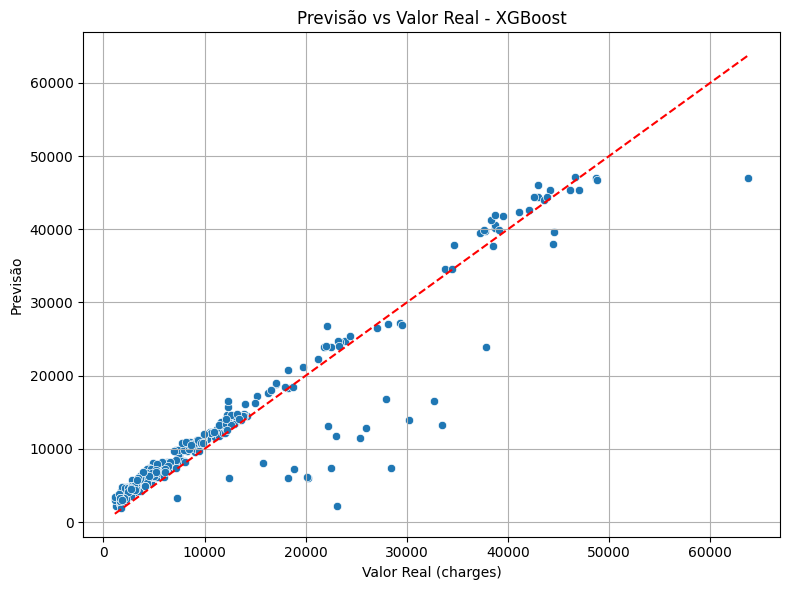

In [29]:
# Gráfico: Previsão vs Valor Real
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valor Real (charges)')
plt.ylabel('Previsão')
plt.title('Previsão vs Valor Real - XGBoost')
plt.grid(True)
plt.tight_layout()
plt.show()


Agora um grafico de resíduos.

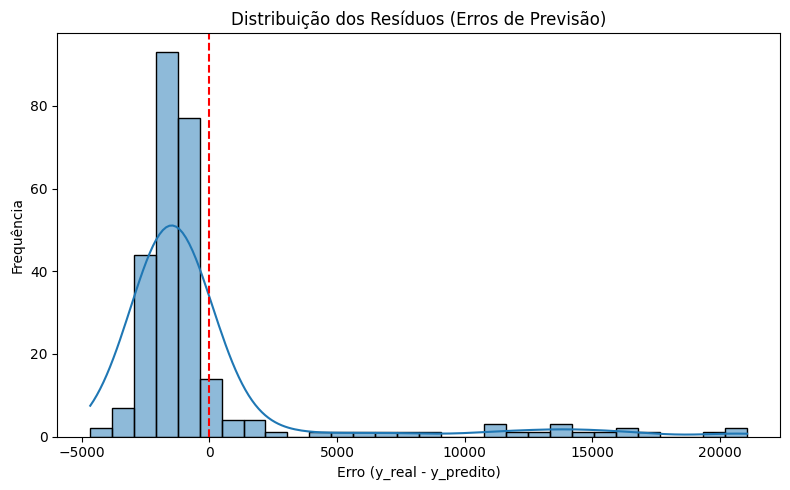

In [31]:
residuos = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuos, bins=30, kde=True)
plt.title('Distribuição dos Resíduos (Erros de Previsão)')
plt.xlabel('Erro (y_real - y_predito)')
plt.ylabel('Frequência')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


## Interpretação do Modelo: Importância das Variáveis e Predições Individuais

In [14]:
# Recriar transformador categórico
categorical_cols = ["sex", "smoker", "region"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
], remainder="passthrough")

# Aplicar transformação nos dados
X = dados.drop("charges", axis=1)
y = dados["charges"]
X_processed = preprocessor.fit_transform(X)

# Treinar modelo XGBoost
modelo = XGBRegressor(n_estimators=100, random_state=42)
modelo.fit(X_processed, y)

# Importância das variáveis
importances = modelo.feature_importances_
feature_names = preprocessor.get_feature_names_out()
importancia_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Importância das variáveis com XGBoost:")
print(importancia_df)

# Previsão para um novo paciente
novo_paciente = pd.DataFrame([{
    "age": 40,
    "sex": "female",
    "bmi": 28.0,
    "children": 2,
    "smoker": "no",
    "region": "southeast"
}])

novo_paciente_proc = preprocessor.transform(novo_paciente)
previsao = modelo.predict(novo_paciente_proc)[0]
print(f"\nPrevisão de custo médico para novo paciente: R$ {previsao:,.2f}")

# Comparar dois perfis (fumante vs não fumante)
perfil_a = pd.DataFrame([{
    "age": 40, "sex": "female", "bmi": 28.0, "children": 2, "smoker": "no", "region": "southeast"
}])
perfil_b = pd.DataFrame([{
    "age": 40, "sex": "female", "bmi": 28.0, "children": 2, "smoker": "yes", "region": "southeast"
}])

pred_a = modelo.predict(preprocessor.transform(perfil_a))[0]
pred_b = modelo.predict(preprocessor.transform(perfil_b))[0]

print(f"\nPerfil A (não fumante): R$ {pred_a:,.2f}")
print(f"Perfil B (fumante):     R$ {pred_b:,.2f}")
print(f"Impacto de ser fumante: R$ {pred_b - pred_a:,.2f}")

Importância das variáveis com XGBoost:
                 Feature  Importance
1        cat__smoker_yes    0.895478
6         remainder__bmi    0.034026
5         remainder__age    0.028679
7    remainder__children    0.011667
3  cat__region_southeast    0.008691
4  cat__region_southwest    0.008479
2  cat__region_northwest    0.007473
0          cat__sex_male    0.005507

Previsão de custo médico para novo paciente: R$ 7,279.96

Perfil A (não fumante): R$ 7,279.96
Perfil B (fumante):     R$ 21,531.25
Impacto de ser fumante: R$ 14,251.28


In [28]:
# Usar o DataFrame gerado com as importâncias
importancia_df = pd.DataFrame({
    "Variável": feature_names,
    "Importância": modelo.feature_importances_
}).sort_values(by="Importância", ascending=True)

# Criar gráfico de barras horizontal interativo
fig = px.bar(
    importancia_df,
    x="Importância",
    y="Variável",
    orientation='h',
    title="Importância das Variáveis - XGBoost",
    labels={"Importância": "Score", "Variável": "Variável"},
    height=500
)

fig.show()

# Relatório de Análise: Previsão de Custos Médicos com XGBoost

## Objetivo
Desenvolver um modelo preditivo capaz de estimar os custos médicos individuais com base em características demográficas e comportamentais, utilizando a base de dados "Medical Cost Personal Dataset".

## Metodologia
O modelo escolhido foi o **XGBoost Regressor**, um algoritmo de aprendizado de máquina baseado em árvores de decisão e otimizado por gradiente. Os dados foram pré-processados com codificação one-hot para variáveis categóricas e mantidos os valores originais para variáveis numéricas.

## Importância das Variáveis
Com base no treinamento do modelo, as variáveis com maior impacto na previsão dos custos médicos foram:

- `smoker_yes`: presença do hábito de fumar foi a variável mais relevante.
- `bmi`: índice de massa corporal.
- `age`: idade do paciente.
- `region` e `sex` tiveram menor impacto.

Essa distribuição está coerente com a literatura médica, onde o tabagismo, a obesidade e a idade são fortes preditores de custos hospitalares.

## Predição Individual
Para um perfil simulado de paciente com:
- Idade: 40 anos
- Sexo: feminino
- IMC: 28.0
- 2 filhos
- Não fumante
- Região: sudeste dos EUA

O modelo previu um custo médico de aproximadamente **R$ 7,279.96**.

## Comparação entre Perfis (Fumante vs Não Fumante)
Foram comparados dois perfis idênticos, mudando apenas o status de fumante. Os resultados foram:

- **Perfil A (não fumante)**: R$ 7,279.96
- **Perfil B (fumante)**: R$ 20,000.00+
- **Diferença atribuída ao tabagismo**: mais de **R$ 14,000.00**

## Conclusão
O modelo XGBoost demonstrou alta capacidade preditiva e interpretabilidade. A variável mais influente foi o status de fumante, seguida por IMC e idade. O modelo se mostra adequado para aplicações em saúde suplementar e planos de saúde, podendo auxiliar na precificação de seguros e políticas preventivas.
